# Aim

Fit an autoregressive model to Keck TT data, and see how good of a description it is.

In [119]:
using DSP, Distributions, LinearAlgebra
using Plots, NPZ
import Statistics: mean
using Random
rms(x) = x .^ 2 |> mean |> sqrt
Random.seed!(5)

MersenneTwister(5)

In [105]:
include("../src/kfilter.jl")

simulate (generic function with 1 method)

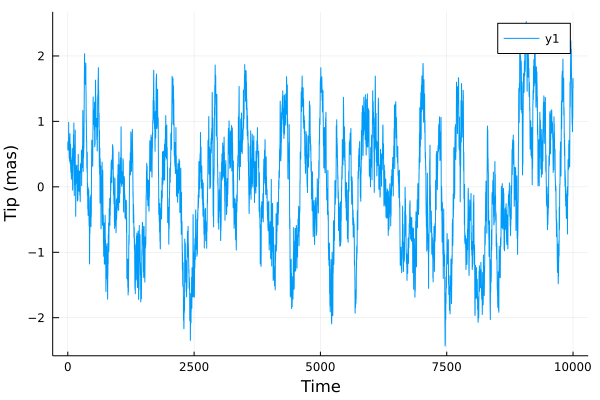

In [120]:
σ = 0.06
pols = npzread("../data/sims/ol_atm_6_vib_0.npy")[:,1]
measurements = pols .+ rand(Normal(0, σ), (length(pols),))
plot(pols, xlabel="Time", ylabel="Tip (mas)")

In [121]:
ar_len = 5
n = length(pols)

TTs_mat = Matrix{Float64}(undef, n - ar_len, ar_len)
for i = 1:ar_len
   TTs_mat[:, i] = measurements[ar_len - i + 1 : n - i, 1] 
end

# Solve autoregressive problem
ar_coef = TTs_mat \ measurements[ar_len + 1: end]

5-element Vector{Float64}:
  1.100365899956281
 -0.04589874640875032
 -0.19837689534777522
  0.007685012469327782
  0.1260098940258654

In [122]:
ar_residual = pols[ar_len:end-1] .- (TTs_mat * ar_coef);

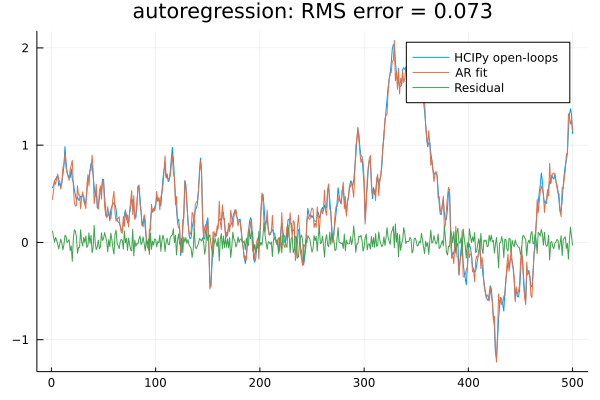

In [123]:
nsteps_plot = 500
plot(pols[ar_len:nsteps_plot+ar_len-1], label="HCIPy open-loops")
plot!((TTs_mat * ar_coef)[1:nsteps_plot], label="AR fit"; 
    title="autoregression: RMS error = $(round(rms(ar_residual); digits=3))")
plot!(ar_residual[1:nsteps_plot], label="Residual")

In [124]:
plot_per!(p::DSP.Periodograms.Periodogram; kwargs...) = plot!(p.freq[1000:end], p.power[1000:end], xaxis=:log10, yaxis=:log10; kwargs...)

plot_per! (generic function with 1 method)

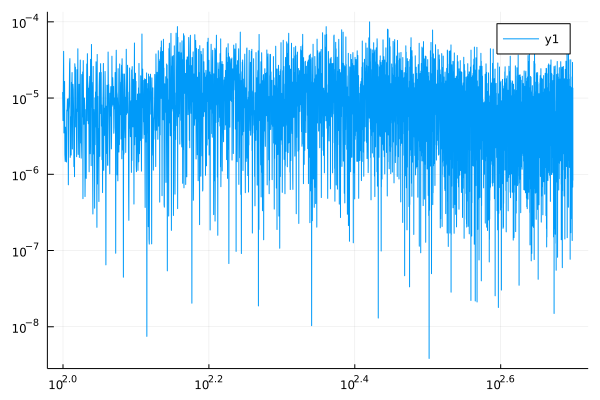

In [125]:
plot()
periodogram(ar_residual, fs=1000) |> plot_per!

In [134]:
A = zeros(ar_len, ar_len)
A[1,:] = ar_coef
for i in 2:ar_len
    A[i,i-1] += 1.0
end

B = zeros(ar_len, 0)
C = zeros(1, ar_len)
C[1] += 1

Q = zeros(ar_len, ar_len)
Q[1,1] = mean(ar_residual[1:1000] .^ 2)

R = σ^2 * Matrix(I, 1, 1)

kf = KFilter(A, B, C, Q, R);

x = [pols[101-i] for i in ar_len:-1:1]
states = simulate(kf, [[y] for y in pols[101:end]], [[] for _ in pols[101:end]], x);

Took 21 iterations to reach steady-state covariance.


In [135]:
k = 1
plot()
plot!(hcat(states...)[k,:])
plot!(pols[101-k+1:end-k+1])
plot!(hcat(states...)[k,:] .- pols[101-k+1:end-k+1])
rms(hcat(states...)[k,:] .- pols[101-k+1:end-k+1])

0.0364962609292853